# STA141B Project

In [2]:
# standard library imports
import csv
import datetime as dt
import json
import os
import statistics
import time

# third-party imports
import numpy as np
import pandas as pd
import requests

# customisations - ensure tables show all columns
pd.set_option("max_columns", 100)

In [3]:
def get_request(url, parameters=None):
    """Return json-formatted response of a get request using optional parameters.
    
    Parameters
    ----------
    url : string
    parameters : {'parameter': 'value'}
        parameters to pass as part of get request
    
    Returns
    -------
    json_data
        json-formatted response (dict-like)
    """
    try:
        response = requests.get(url=url, params=parameters)
    except SSLError as s:
        print('SSL Error:', s)
        
        for i in range(5, 0, -1):
            print('\rWaiting... ({})'.format(i), end='')
            time.sleep(1)
        print('\rRetrying.' + ' '*10)
        
        # recusively try again
        return get_request(url, parameters)
    
    if response:
        return response.json()
    else:
        # response is none usually means too many requests. Wait and try again 
        print('No response, waiting 10 seconds...')
        time.sleep(10)
        print('Retrying.')
        return get_request(url, parameters)


In [4]:
url = "https://steamspy.com/api.php"
parameters = {"request": "all"}

# request 'all' from steam spy and parse into dataframe
json_data = get_request(url, parameters=parameters)
steam_spy_all = pd.DataFrame.from_dict(json_data, orient='index')

# generate sorted app_list from steamspy data
app_list = steam_spy_all[['appid', 'name']].sort_values('appid').reset_index(drop=True)

# export disabled to keep consistency across download sessions
# app_list.to_csv('../data/download/app_list.csv', index=False)

# instead read from stored csv
app_list = pd.read_csv('/Users/amiryaacoobi/Desktop/app_list.csv')

# display first few rows
app_list.head()

,appid,name
0,10,Counter-Strike
1,20,Team Fortress Classic
2,30,Day of Defeat
3,40,Deathmatch Classic
4,50,Half-Life: Opposing Force


In [5]:
def get_app_data(start, stop, parser, pause):
    """Return list of app data generated from parser.
    
    parser : function to handle request
    """
    app_data = []
    
    # iterate through each row of app_list, confined by start and stop
    for index, row in app_list[start:stop].iterrows():
        print('Current index: {}'.format(index), end='\r')
        
        appid = row['appid']
        name = row['name']

        # retrive app data for a row, handled by supplied parser, and append to list
        data = parser(appid, name)
        app_data.append(data)

        time.sleep(pause) # prevent overloading api with requests
    
    return app_data


def process_batches(parser, app_list, download_path, data_filename, index_filename,
                    columns, begin=0, end=-1, batchsize=100, pause=1):
    """Process app data in batches, writing directly to file.
    
    parser : custom function to format request
    app_list : dataframe of appid and name
    download_path : path to store data
    data_filename : filename to save app data
    index_filename : filename to store highest index written
    columns : column names for file
    
    Keyword arguments:
    
    begin : starting index (get from index_filename, default 0)
    end : index to finish (defaults to end of app_list)
    batchsize : number of apps to write in each batch (default 100)
    pause : time to wait after each api request (defualt 1)
    
    returns: none
    """
    print('Starting at index {}:\n'.format(begin))
    
    # by default, process all apps in app_list
    if end == -1:
        end = len(app_list) + 1
    
    # generate array of batch begin and end points
    batches = np.arange(begin, end, batchsize)
    batches = np.append(batches, end)
    
    apps_written = 0
    batch_times = []
    
    for i in range(len(batches) - 1):
        start_time = time.time()
        
        start = batches[i]
        stop = batches[i+1]
        
        app_data = get_app_data(start, stop, parser, pause)
        
        rel_path = os.path.join(download_path, data_filename)
        
        # writing app data to file
        with open(rel_path, 'a', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=columns, extrasaction='ignore')
            
            for j in range(3,0,-1):
                print("\rAbout to write data, don't stop script! ({})".format(j), end='')
                time.sleep(0.5)
            
            writer.writerows(app_data)
            print('\rExported lines {}-{} to {}.'.format(start, stop-1, data_filename), end=' ')
            
        apps_written += len(app_data)
        
        idx_path = os.path.join(download_path, index_filename)
        
        # writing last index to file
        with open(idx_path, 'w') as f:
            index = stop
            print(index, file=f)
            
        # logging time taken
        end_time = time.time()
        time_taken = end_time - start_time
        
        batch_times.append(time_taken)
        mean_time = statistics.mean(batch_times)
        
        est_remaining = (len(batches) - i - 2) * mean_time
        
        remaining_td = dt.timedelta(seconds=round(est_remaining))
        time_td = dt.timedelta(seconds=round(time_taken))
        mean_td = dt.timedelta(seconds=round(mean_time))
        
        print('Batch {} time: {} (avg: {}, remaining: {})'.format(i, time_td, mean_td, remaining_td))
            
    print('\nProcessing batches complete. {} apps written'.format(apps_written))

In [6]:
def reset_index(download_path, index_filename):
    """Reset index in file to 0."""
    rel_path = os.path.join(download_path, index_filename)
    
    with open(rel_path, 'w') as f:
        print(0, file=f)
        

def get_index(download_path, index_filename):
    """Retrieve index from file, returning 0 if file not found."""
    try:
        rel_path = os.path.join(download_path, index_filename)

        with open(rel_path, 'r') as f:
            index = int(f.readline())
    
    except FileNotFoundError:
        index = 0
        
    return index


def prepare_data_file(download_path, filename, index, columns):
    """Create file and write headers if index is 0."""
    if index == 0:
        rel_path = os.path.join(download_path, filename)

        with open(rel_path, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            writer.writeheader()

In [7]:
import pandas as pd
import random
from datetime import datetime

def parse_steam_request(appid, name):
    """Unique parser to handle data from Steam Store API.
    
    Returns : json formatted data (dict-like)
    """
    url = "http://store.steampowered.com/api/appdetails/"
    parameters = {"appids": appid}
    
    json_data = get_request(url, parameters=parameters)
    json_app_data = json_data[str(appid)]
    
    if json_app_data['success']:
        data = json_app_data['data']
        # Parse release date and replace the year with a random year
        release_date_str = data.get('release_date', {}).get('date', '')
        if release_date_str:
            release_date = datetime.strptime(release_date_str, '%b %d, %Y')
            random_year = random.randint(2000, 2020) # Replace with your 20-year period
            randomized_release_date = release_date.replace(year=random_year)
            data['release_date']['date'] = randomized_release_date.strftime('%b %d, %Y')
    else:
        data = {'name': name, 'steam_appid': appid}
        
    return data

# The rest of your code remains the same


def parse_steam_request(appid, name):
    """Unique parser to handle data from Steam Store API.
    
    Returns : json formatted data (dict-like)
    """
    url = "http://store.steampowered.com/api/appdetails/"
    parameters = {"appids": appid}
    
    json_data = get_request(url, parameters=parameters)
    json_app_data = json_data[str(appid)]
    
    if json_app_data['success']:
        data = json_app_data['data']
    else:
        data = {'name': name, 'steam_appid': appid}
        
    return data


# Set file parameters
download_path = '/Users/amiryaacoobi/Desktop'
steam_app_data = 'steam_app_data.csv'
steam_index = 'steam_index.txt'

steam_columns = [
    'type', 'name', 'steam_appid','developers', 'publishers',
    'platforms', 'genres','release_date'
]

# Overwrites last index for demonstration (would usually store highest index so can continue across sessions)
reset_index(download_path, steam_index)

# Retrieve last index downloaded from file
index = get_index(download_path, steam_index)

# Wipe or create data file and write headers if index is 0
prepare_data_file(download_path, steam_app_data, index, steam_columns)

process_batches(
    parser=parse_steam_request,
    app_list=app_list,
    download_path=download_path,
    data_filename=steam_app_data,
    index_filename=steam_index,
    columns=steam_columns,
    begin=index,
    end=200,
    batchsize=5
)

Starting at index 0:

Exported lines 0-4 to steam_app_data.csv. Batch 0 time: 0:00:09 (avg: 0:00:09, remaining: 0:05:41)
Exported lines 5-9 to steam_app_data.csv. Batch 1 time: 0:00:08 (avg: 0:00:09, remaining: 0:05:28)
Exported lines 10-14 to steam_app_data.csv. Batch 2 time: 0:00:09 (avg: 0:00:09, remaining: 0:05:20)
Exported lines 15-19 to steam_app_data.csv. Batch 3 time: 0:00:09 (avg: 0:00:09, remaining: 0:05:11)
Exported lines 20-24 to steam_app_data.csv. Batch 4 time: 0:00:09 (avg: 0:00:09, remaining: 0:05:04)
Exported lines 25-29 to steam_app_data.csv. Batch 5 time: 0:00:09 (avg: 0:00:09, remaining: 0:04:55)
Exported lines 30-34 to steam_app_data.csv. Batch 6 time: 0:00:09 (avg: 0:00:09, remaining: 0:04:47)
Exported lines 35-39 to steam_app_data.csv. Batch 7 time: 0:00:09 (avg: 0:00:09, remaining: 0:04:39)
Exported lines 40-44 to steam_app_data.csv. Batch 8 time: 0:00:09 (avg: 0:00:09, remaining: 0:04:30)
Exported lines 45-49 to steam_app_data.csv. Batch 9 time: 0:00:09 (avg: 0

In [8]:
steam_app_data = pd.read_csv('/Users/amiryaacoobi/Desktop/steam_app_data.csv')


In [9]:
steam_app_data.head()

,type,name,steam_appid,developers,publishers,platforms,genres,release_date
0,game,Counter-Strike,10,['Valve'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'Nov 1, 2000'}"
1,game,Team Fortress Classic,20,['Valve'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'Apr 1, 1999'}"
2,game,Day of Defeat,30,['Valve'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'May 1, 2003'}"
3,game,Deathmatch Classic,40,['Valve'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'Jun 1, 2001'}"
4,game,Half-Life: Opposing Force,50,['Gearbox Software'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'Nov 1, 1999'}"


In [10]:
def parse_steamspy_request(appid, name):
    """Parser to handle SteamSpy API data."""
    url = "https://steamspy.com/api.php"
    parameters = {"request": "appdetails", "appid": appid}
    
    json_data = get_request(url, parameters)
    return json_data


# set files and columns
download_path = '/Users/amiryaacoobi/Desktop'
steamspy_data = 'steamspy_data.csv'
steamspy_index = 'steamspy_index.txt'

steamspy_columns = [
    'appid', 'name', 'developer', 'publisher', 'positive',
    'negative', 'owners', 'price',
     'genre', 'ccu', 'tags'
]

reset_index(download_path, steamspy_index)
index = get_index(download_path, steamspy_index)

# Wipe data file if index is 0
prepare_data_file(download_path, steamspy_data, index, steamspy_columns)

process_batches(
    parser=parse_steamspy_request,
    app_list=app_list,
    download_path=download_path, 
    data_filename=steamspy_data,
    index_filename=steamspy_index,
    columns=steamspy_columns,
    begin=index,
    end=200,
    batchsize=5,
    pause=0.3
)

Starting at index 0:

Exported lines 0-4 to steamspy_data.csv. Batch 0 time: 0:00:05 (avg: 0:00:05, remaining: 0:03:23)
Exported lines 5-9 to steamspy_data.csv. Batch 1 time: 0:00:05 (avg: 0:00:05, remaining: 0:03:07)
Exported lines 10-14 to steamspy_data.csv. Batch 2 time: 0:00:05 (avg: 0:00:05, remaining: 0:03:02)
Exported lines 15-19 to steamspy_data.csv. Batch 3 time: 0:00:05 (avg: 0:00:05, remaining: 0:02:54)
Exported lines 20-24 to steamspy_data.csv. Batch 4 time: 0:00:05 (avg: 0:00:05, remaining: 0:02:48)
Exported lines 25-29 to steamspy_data.csv. Batch 5 time: 0:00:05 (avg: 0:00:05, remaining: 0:02:43)
Exported lines 30-34 to steamspy_data.csv. Batch 6 time: 0:00:05 (avg: 0:00:05, remaining: 0:02:38)
Exported lines 35-39 to steamspy_data.csv. Batch 7 time: 0:00:06 (avg: 0:00:05, remaining: 0:02:36)
Exported lines 40-44 to steamspy_data.csv. Batch 8 time: 0:00:05 (avg: 0:00:05, remaining: 0:02:31)
Exported lines 45-49 to steamspy_data.csv. Batch 9 time: 0:00:05 (avg: 0:00:05, re

In [13]:
steamspy_data = pd.read_csv('/Users/amiryaacoobi/Desktop/steamspy_data.csv')


In [14]:
steamspy_data.head()

,appid,name,developer,publisher,positive,negative,owners,price,genre,ccu,tags
0,10,Counter-Strike,Valve,Valve,225427,5861,"10,000,000 .. 20,000,000",999,Action,9927,"{'Action': 5455, 'FPS': 4880, 'Multiplayer': 3..."
1,20,Team Fortress Classic,Valve,Valve,6811,1041,"5,000,000 .. 10,000,000",499,Action,76,"{'Action': 760, 'FPS': 321, 'Multiplayer': 273..."
2,30,Day of Defeat,Valve,Valve,5913,662,"5,000,000 .. 10,000,000",499,Action,103,"{'FPS': 795, 'World War II': 266, 'Multiplayer..."
3,40,Deathmatch Classic,Valve,Valve,2336,501,"5,000,000 .. 10,000,000",499,Action,10,"{'Action': 632, 'FPS': 147, 'Classic': 112, 'M..."
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,19302,971,"2,000,000 .. 5,000,000",499,Action,232,"{'FPS': 910, 'Action': 346, 'Classic': 275, 'S..."


now, after cleaning each of the individual datasets we got from accessing the SteamAPI, we want to combine dd_cleaned and df_cleaned,
to begin our data visualization and answer the quesiton

In [15]:
# Rename the 'appid' column
steamspy_data = steamspy_data.rename(columns={'appid': 'steam_appid'})

# Merge the two dataframes on 'steam_appid'
combined_df = pd.merge(steamspy_data, steam_app_data, how = 'inner', on='steam_appid')


In [16]:
combined_df.head()

,steam_appid,name_x,developer,publisher,positive,negative,owners,price,genre,ccu,tags,type,name_y,developers,publishers,platforms,genres,release_date
0,10,Counter-Strike,Valve,Valve,225427,5861,"10,000,000 .. 20,000,000",999,Action,9927,"{'Action': 5455, 'FPS': 4880, 'Multiplayer': 3...",game,Counter-Strike,['Valve'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'Nov 1, 2000'}"
1,20,Team Fortress Classic,Valve,Valve,6811,1041,"5,000,000 .. 10,000,000",499,Action,76,"{'Action': 760, 'FPS': 321, 'Multiplayer': 273...",game,Team Fortress Classic,['Valve'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'Apr 1, 1999'}"
2,30,Day of Defeat,Valve,Valve,5913,662,"5,000,000 .. 10,000,000",499,Action,103,"{'FPS': 795, 'World War II': 266, 'Multiplayer...",game,Day of Defeat,['Valve'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'May 1, 2003'}"
3,40,Deathmatch Classic,Valve,Valve,2336,501,"5,000,000 .. 10,000,000",499,Action,10,"{'Action': 632, 'FPS': 147, 'Classic': 112, 'M...",game,Deathmatch Classic,['Valve'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'Jun 1, 2001'}"
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,19302,971,"2,000,000 .. 5,000,000",499,Action,232,"{'FPS': 910, 'Action': 346, 'Classic': 275, 'S...",game,Half-Life: Opposing Force,['Gearbox Software'],['Valve'],"{'windows': True, 'mac': True, 'linux': True}","[{'id': '1', 'description': 'Action'}]","{'coming_soon': False, 'date': 'Nov 1, 1999'}"


In [17]:
# now we want to work by cleaning up the data, starting with making figures accurately reflect what they are

In [18]:
# Remove redundant columns with '_y' suffix
columns_to_drop = ['name_y', 'developers', 'publishers', 'genres']
combined_df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Rename columns with '_x' suffix to remove the suffix
combined_df.rename(columns={'name_x': 'name', 
                            'release_date_x': 'release_date'}, 
                   inplace=True)

# Now combined_df has the cleaned-up columns.
combined_df['price'] = combined_df['price'] / 100

# Add a new column 'reviews' which is the sum of 'positive' and 'negative' columns
combined_df['reviews'] = combined_df['positive'] + combined_df['negative']

# Apply the Boxleitner method to estimate sales
sales_review_ratio = 35  # As per the information provided
combined_df['estimated_sales'] = combined_df['reviews'] * sales_review_ratio

# Assuming the 'price' column is in the dataframe and represents the game price
# Calculate estimated revenue by multiplying the estimated sales by the game price
combined_df['estimated_revenue'] = combined_df['estimated_sales'] * combined_df['price']
combined_df['positive_review_percentage'] = ((combined_df['positive'] / (combined_df['positive'] + combined_df['negative'])) * 100).round(1).astype(str) + '%'
combined_df['estimated_revenue'] = combined_df['estimated_revenue'].map('${:,.2f}'.format)




In [19]:
combined_df.head()

,steam_appid,name,developer,publisher,positive,negative,owners,price,genre,ccu,tags,type,platforms,release_date,reviews,estimated_sales,estimated_revenue,positive_review_percentage
0,10,Counter-Strike,Valve,Valve,225427,5861,"10,000,000 .. 20,000,000",9.99,Action,9927,"{'Action': 5455, 'FPS': 4880, 'Multiplayer': 3...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Nov 1, 2000'}",231288,8095080,"$80,869,849.20",97.5%
1,20,Team Fortress Classic,Valve,Valve,6811,1041,"5,000,000 .. 10,000,000",4.99,Action,76,"{'Action': 760, 'FPS': 321, 'Multiplayer': 273...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Apr 1, 1999'}",7852,274820,"$1,371,351.80",86.7%
2,30,Day of Defeat,Valve,Valve,5913,662,"5,000,000 .. 10,000,000",4.99,Action,103,"{'FPS': 795, 'World War II': 266, 'Multiplayer...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'May 1, 2003'}",6575,230125,"$1,148,323.75",89.9%
3,40,Deathmatch Classic,Valve,Valve,2336,501,"5,000,000 .. 10,000,000",4.99,Action,10,"{'Action': 632, 'FPS': 147, 'Classic': 112, 'M...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Jun 1, 2001'}",2837,99295,"$495,482.05",82.3%
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,19302,971,"2,000,000 .. 5,000,000",4.99,Action,232,"{'FPS': 910, 'Action': 346, 'Classic': 275, 'S...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Nov 1, 1999'}",20273,709555,"$3,540,679.45",95.2%


In [20]:


# Add a new column 'reviews' which is the sum of 'positive' and 'negative' columns
combined_df['reviews'] = combined_df['positive'] + combined_df['negative']

# Apply the Boxleitner method to estimate sales
sales_review_ratio = 35  # As per the information provided
combined_df['estimated_sales'] = combined_df['reviews'] * sales_review_ratio

# Assuming the 'price' column is in the dataframe and represents the game price
# Calculate estimated revenue by multiplying the estimated sales by the game price
combined_df['estimated_revenue'] = combined_df['estimated_sales'] * combined_df['price']
combined_df['positive_review_percentage'] = ((combined_df['positive'] / (combined_df['positive'] + combined_df['negative'])) * 100).round(1).astype(str) + '%'
combined_df['estimated_revenue'] = combined_df['estimated_revenue'].map('${:,.2f}'.format)


In [21]:
combined_df.head(100)

,steam_appid,name,developer,publisher,positive,negative,owners,price,genre,ccu,tags,type,platforms,release_date,reviews,estimated_sales,estimated_revenue,positive_review_percentage
0,10,Counter-Strike,Valve,Valve,225427,5861,"10,000,000 .. 20,000,000",9.99,Action,9927,"{'Action': 5455, 'FPS': 4880, 'Multiplayer': 3...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Nov 1, 2000'}",231288,8095080,"$80,869,849.20",97.5%
1,20,Team Fortress Classic,Valve,Valve,6811,1041,"5,000,000 .. 10,000,000",4.99,Action,76,"{'Action': 760, 'FPS': 321, 'Multiplayer': 273...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Apr 1, 1999'}",7852,274820,"$1,371,351.80",86.7%
2,30,Day of Defeat,Valve,Valve,5913,662,"5,000,000 .. 10,000,000",4.99,Action,103,"{'FPS': 795, 'World War II': 266, 'Multiplayer...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'May 1, 2003'}",6575,230125,"$1,148,323.75",89.9%
3,40,Deathmatch Classic,Valve,Valve,2336,501,"5,000,000 .. 10,000,000",4.99,Action,10,"{'Action': 632, 'FPS': 147, 'Classic': 112, 'M...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Jun 1, 2001'}",2837,99295,"$495,482.05",82.3%
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,19302,971,"2,000,000 .. 5,000,000",4.99,Action,232,"{'FPS': 910, 'Action': 346, 'Classic': 275, 'S...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Nov 1, 1999'}",20273,709555,"$3,540,679.45",95.2%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3260,Safecracker: The Ultimate Puzzle Adventure,Kheops Studio,HandyGames,332,239,"100,000 .. 200,000",4.99,"Adventure, Casual",1,"{'Puzzle': 53, 'Adventure': 40, 'Casual': 31, ...",game,"{'windows': True, 'mac': False, 'linux': False}","{'coming_soon': False, 'date': 'Aug 29, 2007'}",571,19985,"$99,725.15",58.1%
96,3270,Painkiller Overdose,Mindware Studios,Prime Matter,737,266,"100,000 .. 200,000",4.99,Action,4,"{'Action': 57, 'FPS': 34, 'Shooter': 20, 'Horr...",game,"{'windows': True, 'mac': False, 'linux': False}","{'coming_soon': False, 'date': 'Oct 30, 2007'}",1003,35105,"$175,173.95",73.5%
97,3300,Bejeweled 2 Deluxe,"PopCap Games, Inc.","PopCap Games, Inc., Electronic Arts",470,24,"50,000 .. 100,000",4.99,Casual,46,"{'Casual': 56, 'Puzzle': 30, 'Match 3': 29, 'G...",game,"{'windows': True, 'mac': True, 'linux': False}","{'coming_soon': False, 'date': 'Aug 30, 2006'}",494,17290,"$86,277.10",95.1%
98,3310,Chuzzle Deluxe,"PopCap Games, Inc.","PopCap Games, Inc., Electronic Arts",856,61,"100,000 .. 200,000",4.99,Casual,90,"{'Casual': 69, 'Puzzle': 36, 'Match 3': 25, 'S...",game,"{'windows': True, 'mac': True, 'linux': False}","{'coming_soon': False, 'date': 'Aug 30, 2006'}",917,32095,"$160,154.05",93.3%


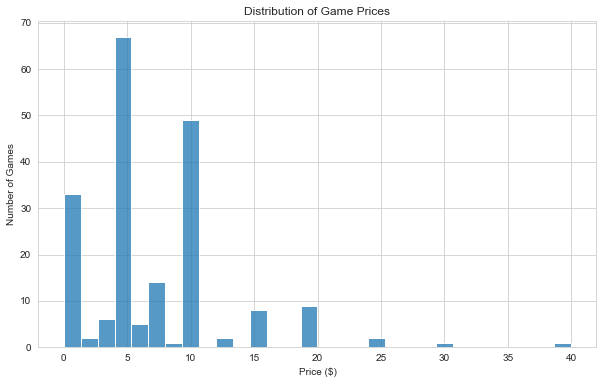

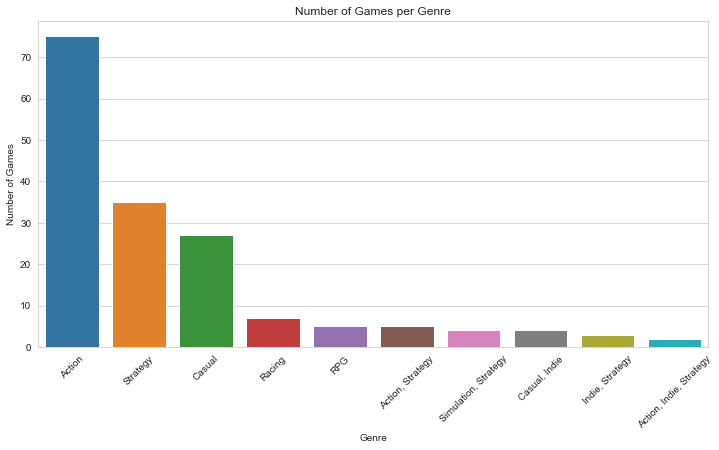

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Histogram of the game prices
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['price'], kde=False, bins=30)
plt.title('Distribution of Game Prices')
plt.xlabel('Price ($)')
plt.ylabel('Number of Games')
plt.show()


# Bar chart of the number of games per genre
# This assumes 'genre' column contains simple text data; if it's nested JSON, it needs to be processed first
genre_counts = combined_df['genre'].value_counts().head(10)  # Top 10 genres
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Number of Games per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.show()


We will now use a supplementary dataset that has a full range of what we want to use for our exploration: 

In [23]:
# Load the supplementary dataset
steam = pd.read_csv('/Users/amiryaacoobi/Desktop/steam.csv')


In [24]:
len(steam)

27075

In [25]:

# Calculate estimated revenue by multiplying the estimated sales by the game price
# Add a new column 'reviews' which is the sum of 'positive' and 'negative' columns
steam['reviews'] = steam['positive_ratings'] + steam['negative_ratings']

# Apply the Boxleitner method to estimate sales
sales_review_ratio = 35  # As per the information provided
steam['estimated_sales'] = steam['reviews'] * sales_review_ratio
steam['estimated_revenue'] = steam['estimated_sales'] * steam['price']
steam['positive_review_percentage'] = ((steam['positive_ratings'] / (steam['positive_ratings'] + steam['negative_ratings'])) * 100).round(1).astype(str) + '%'
steam['estimated_revenue'] = steam['estimated_revenue'].map('${:,.2f}'.format)

In [26]:
steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,reviews,estimated_sales,estimated_revenue,positive_review_percentage
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,127873,4475555,"$32,179,240.45",97.4%
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,3951,138285,"$551,757.15",84.0%
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,3814,133490,"$532,625.10",89.6%
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,1540,53900,"$215,061.00",82.7%
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,5538,193830,"$773,381.70",94.8%


In [27]:
len(steam) #find the number of games included in our Kaggle Dataset

27075

In [28]:
# Merge the two dataframes on 'steam_appid', which combines our API extracted data with a supplementary dataset
steam = steam.rename(columns={'appid': 'steam_appid'})
real_data = pd.merge(steam, combined_df, how = 'left', on='steam_appid')



In [29]:
real_data.head()

,steam_appid,name_x,release_date_x,english,developer_x,publisher_x,platforms_x,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners_x,price_x,reviews_x,estimated_sales_x,estimated_revenue_x,positive_review_percentage_x,name_y,developer_y,publisher_y,positive,negative,owners_y,price_y,genre,ccu,tags,type,platforms_y,release_date_y,reviews_y,estimated_sales_y,estimated_revenue_y,positive_review_percentage_y
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,127873,4475555,"$32,179,240.45",97.4%,Counter-Strike,Valve,Valve,225427.0,5861.0,"10,000,000 .. 20,000,000",9.99,Action,9927.0,"{'Action': 5455, 'FPS': 4880, 'Multiplayer': 3...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Nov 1, 2000'}",231288.0,8095080.0,"$80,869,849.20",97.5%
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,3951,138285,"$551,757.15",84.0%,Team Fortress Classic,Valve,Valve,6811.0,1041.0,"5,000,000 .. 10,000,000",4.99,Action,76.0,"{'Action': 760, 'FPS': 321, 'Multiplayer': 273...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Apr 1, 1999'}",7852.0,274820.0,"$1,371,351.80",86.7%
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,3814,133490,"$532,625.10",89.6%,Day of Defeat,Valve,Valve,5913.0,662.0,"5,000,000 .. 10,000,000",4.99,Action,103.0,"{'FPS': 795, 'World War II': 266, 'Multiplayer...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'May 1, 2003'}",6575.0,230125.0,"$1,148,323.75",89.9%
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,1540,53900,"$215,061.00",82.7%,Deathmatch Classic,Valve,Valve,2336.0,501.0,"5,000,000 .. 10,000,000",4.99,Action,10.0,"{'Action': 632, 'FPS': 147, 'Classic': 112, 'M...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Jun 1, 2001'}",2837.0,99295.0,"$495,482.05",82.3%
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,5538,193830,"$773,381.70",94.8%,Half-Life: Opposing Force,Gearbox Software,Valve,19302.0,971.0,"2,000,000 .. 5,000,000",4.99,Action,232.0,"{'FPS': 910, 'Action': 346, 'Classic': 275, 'S...",game,"{'windows': True, 'mac': True, 'linux': True}","{'coming_soon': False, 'date': 'Nov 1, 1999'}",20273.0,709555.0,"$3,540,679.45",95.2%


In [30]:
len(real_data)

27076

In [31]:
def clean_data(df):
    # Remove columns ending with '_y'
    df = df[df.columns.drop(list(df.filter(regex='_y')))]
    
    # Remove specific columns
    columns_to_remove = ["positive", "negative", "english", "required_age", "achievements", "tags", "median_playtime", "average_playtime", "type"]
    df.drop(columns=columns_to_remove, errors='ignore', inplace=True)

    # Rename columns ending with '_x' by removing '_x'
    df.columns = df.columns.str.replace('_x$', '', regex=True)
    
    return df

# Apply the function to real_data
real_data = clean_data(real_data)

# To view the updated DataFrame
real_data.head()


/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,steam_appid,name,release_date,developer,publisher,platforms,categories,genres,steamspy_tags,positive_ratings,negative_ratings,owners,price,reviews,estimated_sales,estimated_revenue,positive_review_percentage,genre,ccu
0,10,Counter-Strike,2000-11-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,124534,3339,10000000-20000000,7.19,127873,4475555,"$32,179,240.45",97.4%,Action,9927.0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,3318,633,5000000-10000000,3.99,3951,138285,"$551,757.15",84.0%,Action,76.0
2,30,Day of Defeat,2003-05-01,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,3416,398,5000000-10000000,3.99,3814,133490,"$532,625.10",89.6%,Action,103.0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,1273,267,5000000-10000000,3.99,1540,53900,"$215,061.00",82.7%,Action,10.0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,5250,288,5000000-10000000,3.99,5538,193830,"$773,381.70",94.8%,Action,232.0


In [32]:
columns = real_data.columns.tolist()
print(columns)
len(real_data)

['steam_appid', 'name', 'release_date', 'developer', 'publisher', 'platforms', 'categories', 'genres', 'steamspy_tags', 'positive_ratings', 'negative_ratings', 'owners', 'price', 'reviews', 'estimated_sales', 'estimated_revenue', 'positive_review_percentage', 'genre', 'ccu']


27076

In [33]:
real_data.head(15)

,steam_appid,name,release_date,developer,publisher,platforms,categories,genres,steamspy_tags,positive_ratings,negative_ratings,owners,price,reviews,estimated_sales,estimated_revenue,positive_review_percentage,genre,ccu
0,10,Counter-Strike,2000-11-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,124534,3339,10000000-20000000,7.19,127873,4475555,"$32,179,240.45",97.4%,Action,9927.0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,3318,633,5000000-10000000,3.99,3951,138285,"$551,757.15",84.0%,Action,76.0
2,30,Day of Defeat,2003-05-01,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,3416,398,5000000-10000000,3.99,3814,133490,"$532,625.10",89.6%,Action,103.0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,1273,267,5000000-10000000,3.99,1540,53900,"$215,061.00",82.7%,Action,10.0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,5250,288,5000000-10000000,3.99,5538,193830,"$773,381.70",94.8%,Action,232.0
5,60,Ricochet,2000-11-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,2758,684,5000000-10000000,3.99,3442,120470,"$480,675.30",80.1%,Action,16.0
6,70,Half-Life,1998-11-08,Valve,Valve,windows;mac;linux,Single-player;Multi-player;Online Multi-Player...,Action,FPS;Classic;Action,27755,1100,5000000-10000000,7.19,28855,1009925,"$7,261,360.75",96.2%,Action,2957.0
7,80,Counter-Strike: Condition Zero,2004-03-01,Valve,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,Action;FPS;Multiplayer,12120,1439,10000000-20000000,7.19,13559,474565,"$3,412,122.35",89.4%,Action,343.0
8,130,Half-Life: Blue Shift,2001-06-01,Gearbox Software,Valve,windows;mac;linux,Single-player,Action,FPS;Action;Sci-fi,3822,420,5000000-10000000,3.99,4242,148470,"$592,395.30",90.1%,Action,105.0
9,220,Half-Life 2,2004-11-16,Valve,Valve,windows;mac;linux,Single-player;Steam Achievements;Steam Trading...,Action,FPS;Action;Sci-fi,67902,2419,10000000-20000000,7.19,70321,2461235,"$17,696,279.65",96.6%,Action,1673.0


In [34]:
# Convert 'release_date' to datetime
real_data['release_date'] = pd.to_datetime(real_data['release_date'])

# Extract the year from 'release_date' and create a new column 'release_year'
real_data['release_year'] = real_data['release_date'].dt.year

# Now you can view the DataFrame with the new 'release_year' column
print(real_data[['release_date', 'release_year']].head())


  release_date  release_year
0   2000-11-01          2000
1   1999-04-01          1999
2   2003-05-01          2003
3   2001-06-01          2001
4   1999-11-01          1999


# VISUALIZATIONS

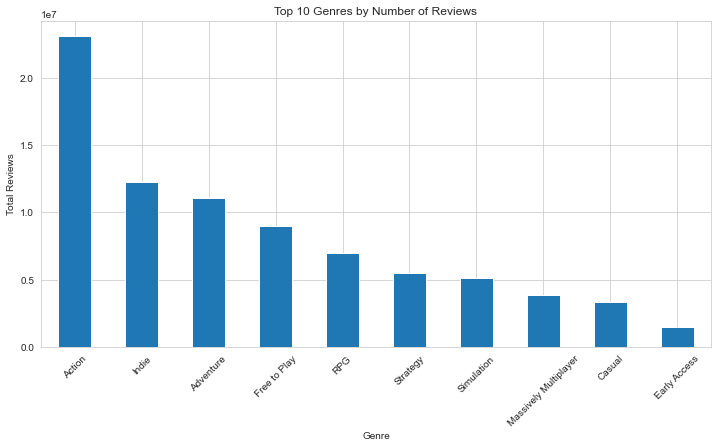

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'reviews' column contains the number of reviews for each game
# and 'genres' column contains the genre information

# Split the 'genres' column (if multiple genres are listed per game) and explode it
expanded_genres = real_data.assign(genres=real_data['genres'].str.split(';')).explode('genres')

# Group by genres and sum up the reviews
genre_review_counts = expanded_genres.groupby('genres')['reviews'].sum()

# Sort and select the top 10 genres
top_10_genres = genre_review_counts.sort_values(ascending=False).head(10)

# Plotting the histogram
plt.figure(figsize=(12, 6))
top_10_genres.plot(kind='bar')
plt.title('Top 10 Genres by Number of Reviews')
plt.xlabel('Genre')
plt.ylabel('Total Reviews')
plt.xticks(rotation=45)
plt.show()


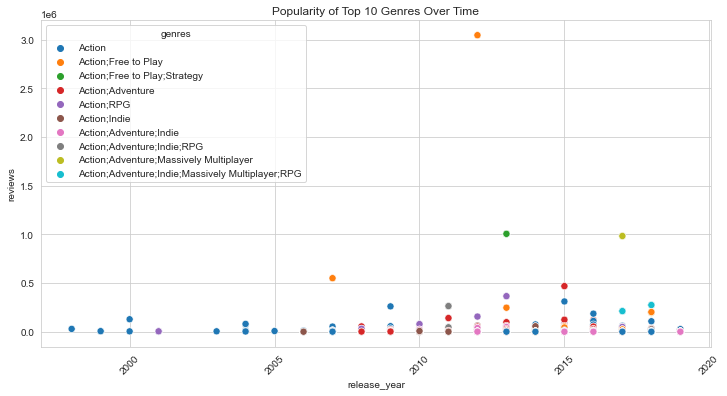

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'reviews', 'genres', and 'release_date' columns exist in real_data

# Split the 'genres' column if multiple genres are listed per game and explode it
expanded_genres = real_data.assign(genre=real_data['genres'].str.split(';')).explode('genre')

# Identify the top 10 genres based on total reviews
top_10_genres = expanded_genres.groupby('genres')['reviews'].sum().sort_values(ascending=False).head(10).index

# Filter the dataset to include only the top 10 genres
top_genres_data = expanded_genres[expanded_genres['genres'].isin(top_10_genres)]

# Create the scatter plot
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(x="release_year", y="reviews", hue="genres", data=top_genres_data, s=50) # `s` is the size of the points
ax.set_title("Popularity of Top 10 Genres Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()



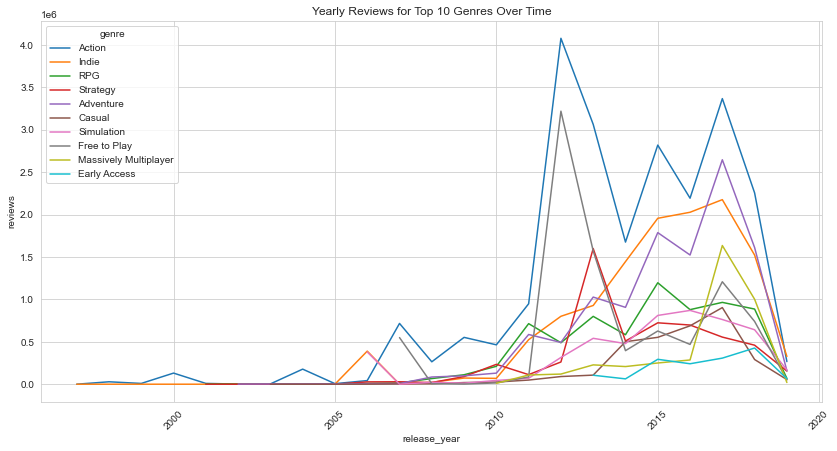

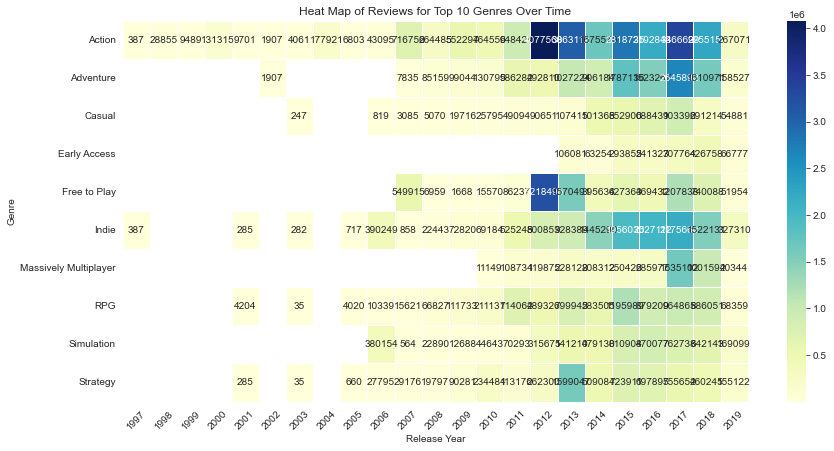

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'release_date' to datetime and extract the year
real_data['release_date'] = pd.to_datetime(real_data['release_date'])
real_data['release_year'] = real_data['release_date'].dt.year

# Split the 'genres' column if multiple genres are listed per game and explode it
expanded_genres = real_data.assign(genre=real_data['genres'].str.split(';')).explode('genre')

# Aggregate the data to get the total reviews for each genre per year
genre_yearly_reviews = expanded_genres.groupby(['release_year', 'genre'])['reviews'].sum().reset_index()

# Identify the top genres based on total reviews across all years
top_genres = genre_yearly_reviews.groupby('genre')['reviews'].sum().sort_values(ascending=False).head(10).index

# Filter the dataset to include only the top genres
top_genre_yearly_reviews = genre_yearly_reviews[genre_yearly_reviews['genre'].isin(top_genres)]

# Line plot for genre popularity over time based on reviews
plt.figure(figsize=(14, 7))
lineplot_ax = sns.lineplot(data=top_genre_yearly_reviews, x='release_year', y='reviews', hue='genre')
lineplot_ax.set_title('Yearly Reviews for Top 10 Genres Over Time')
plt.xticks(rotation=45)
plt.show()

# Heat map for the number of reviews per genre over each year
plt.figure(figsize=(14, 7))
# Pivot table for heat map
pivot_table = top_genre_yearly_reviews.pivot('genre', 'release_year', 'reviews')
heatmap_ax = sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f")
heatmap_ax.set_title('Heat Map of Reviews for Top 10 Genres Over Time')
heatmap_ax.set_xlabel('Release Year')  # Set the x-axis label
heatmap_ax.set_ylabel('Genre')  # Set the y-axis label
plt.xticks(rotation=45)
plt.yticks(rotation=0)  # Keep the y-axis labels horizontal for readability
plt.show()


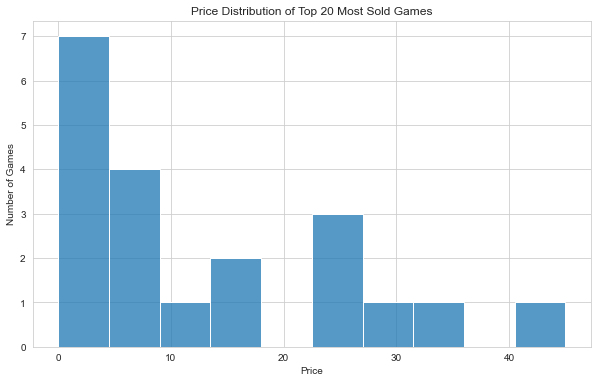

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sort the data by 'estimated_sales' and select the top 20
top_20_sales = real_data.sort_values(by='estimated_sales', ascending=False).head(20)

# Histogram for the 'price' of the top 20 most sold games
plt.figure(figsize=(10, 6))
sns.histplot(top_20_sales['price'], bins=10, kde=False)  # Adjust bins if necessary
plt.title('Price Distribution of Top 20 Most Sold Games')
plt.xlabel('Price')
plt.ylabel('Number of Games')
plt.show()



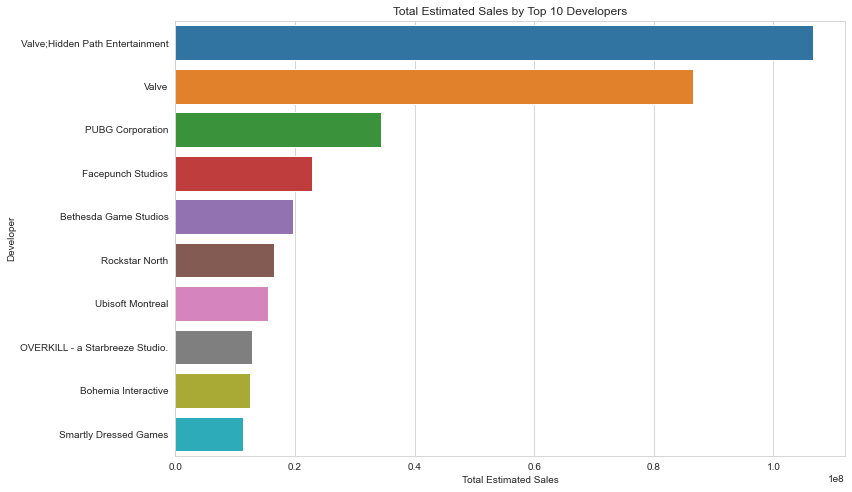

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate estimated sales by developer
developer_sales = real_data.groupby('developer')['estimated_sales'].sum().sort_values(ascending=False).head(10)

# Get the names of the top 10 developers
top_developers = developer_sales.index.tolist()

# Filter the dataset to include only games by the top 10 developers
top_developers_data = real_data[real_data['developer'].isin(top_developers)]

# Bar Plot for estimated sales by the top 10 developers
plt.figure(figsize=(12, 8))
barplot_ax = sns.barplot(x=developer_sales.values, y=top_developers, order=top_developers)
barplot_ax.set_title('Total Estimated Sales by Top 10 Developers')
barplot_ax.set_xlabel('Total Estimated Sales')  # Set the x-axis label
barplot_ax.set_ylabel('Developer')  # Set the y-axis label
plt.show()


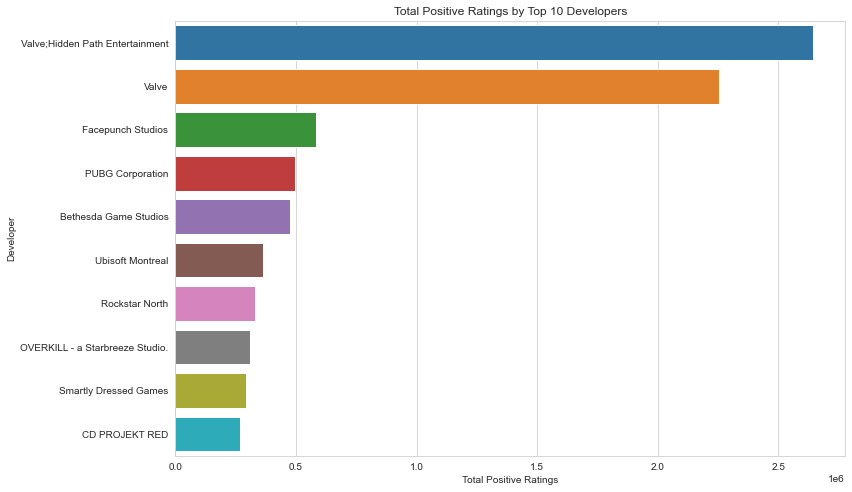

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate positive ratings by developer
developer_positive_ratings = real_data.groupby('developer')['positive_ratings'].sum().sort_values(ascending=False).head(10)

# Get the names of the top 10 developers
top_developers = developer_positive_ratings.index.tolist()

# Filter the dataset to include only games by the top 10 developers
top_developers_data = real_data[real_data['developer'].isin(top_developers)]

# Bar Plot for total positive ratings by the top 10 developers
plt.figure(figsize=(12, 8))
barplot_ax = sns.barplot(x=developer_positive_ratings.values, y=top_developers, order=top_developers)
barplot_ax.set_title('Total Positive Ratings by Top 10 Developers')
barplot_ax.set_xlabel('Total Positive Ratings')  # Set the x-axis label
barplot_ax.set_ylabel('Developer')  # Set the y-axis label
plt.show()
